In [14]:
import os
import json
from glob import glob

import pandas as pd
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

import shared.utils as su

In [2]:
result_dir = "/work/piyush/experiments/CaRe/Tarsier-7b/fractions_10k"
!ls $result_dir

nli-0.0+ego-1.0  nli-0.3+ego-0.7  nli-0.6+ego-0.4  nli-0.9+ego-0.1
nli-0.1+ego-0.9  nli-0.4+ego-0.6  nli-0.7+ego-0.3  nli-1.0+ego-0.0
nli-0.2+ego-0.8  nli-0.5+ego-0.5  nli-0.8+ego-0.2


In [3]:
metric_files = natsorted(glob(f"{result_dir}/*/metrics/metrics-ssv2.json"))
len(metric_files)

11

In [76]:
def compute_rebias(data):
    r_temporal = (
    data['metrics_pair']['txt_r1'] + \
    data['metrics_pair']['txt_r5'] + \
    data['metrics_pair']['txt_r10'] + \
    data['metrics_pair']['img_r1'] + \
    data['metrics_pair']['img_r5'] + \
    data['metrics_pair']['img_r10']
    ) / 6.
    
    r_spatial = (
    data['metrics_stat']['txt_r1'] + \
    data['metrics_stat']['txt_r5'] + \
    data['metrics_stat']['txt_r10'] + \
    data['metrics_stat']['img_r1'] + \
    data['metrics_stat']['img_r5'] + \
    data['metrics_stat']['img_r10']
    ) / 6.
    
    rebias = np.abs(1 - (r_spatial/r_temporal))
    return np.round(rebias * 100., 2)

In [77]:
df = []
rebiases = []
for f in metric_files:
    split = f.split("/")[-3]
    data = su.io.load_json(f)
    df.append(
        {'split': split, }
    )
    print(split)
    txt_ = 'txt_r1'
    img_ = 'img_map'
    # img_ = 'img_r1'
    array = np.round(
        np.array([
            data['metrics_pair'][txt_], 
            data['metrics_stat'][txt_],
            data['metrics_base'][txt_],
            data['metrics_pair'][img_],
            data['metrics_stat'][img_],
            data['metrics_base'][img_],
        ]),
        1,
    )
    print(array)
    rebias = compute_rebias(data)
    print(rebias)
    print("-" * 100)
    rebiases.append(rebias)

nli-0.0+ego-1.0
[83.5 56.2 43.8 84.2 39.6 31.3]
22.58
----------------------------------------------------------------------------------------------------
nli-0.1+ego-0.9
[85.2 54.  42.1 83.8 41.5 32.5]
18.95
----------------------------------------------------------------------------------------------------
nli-0.2+ego-0.8
[83.8 55.  42.8 84.5 39.7 30.7]
20.76
----------------------------------------------------------------------------------------------------
nli-0.3+ego-0.7
[83.3 54.3 41.4 83.2 39.1 30.6]
23.73
----------------------------------------------------------------------------------------------------
nli-0.4+ego-0.6
[84.8 57.3 45.7 85.5 41.2 32.2]
21.02
----------------------------------------------------------------------------------------------------
nli-0.5+ego-0.5
[84.4 57.4 46.2 85.5 41.9 33. ]
21.83
----------------------------------------------------------------------------------------------------
nli-0.6+ego-0.4
[82.9 55.2 41.6 84.1 39.2 30.5]
23.76
----------------

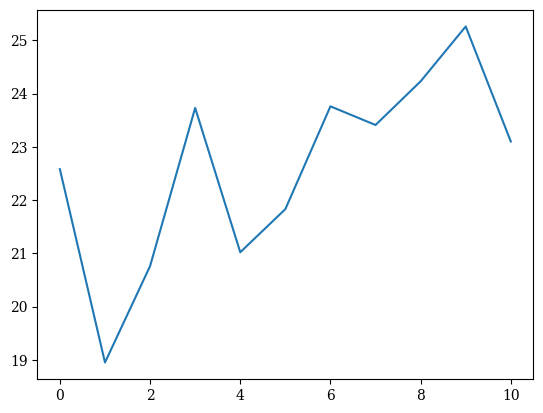

In [78]:
plt.plot(rebiases)

np.float64(0.30040858423578864)

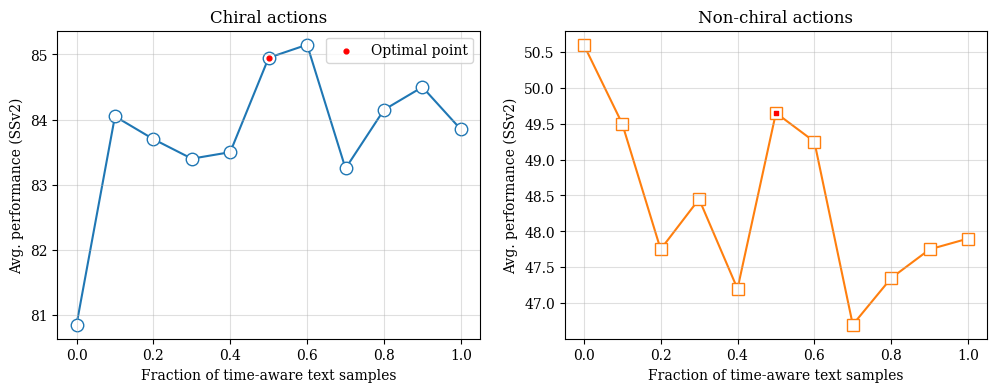

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the data
data = {
    "ego_fraction": [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0],
    "V2T_Chiral": [83.5, 85.2, 83.8, 83.3, 84.8, 84.4, 82.9, 83.0, 84.8, 84.6, 82.1],
    "V2T_NonChiral": [56.2, 54.0, 55.0, 54.3, 57.3, 57.4, 55.2, 56.6, 56.4, 60.2, 62.3],
    "T2V_Chiral": [84.2, 83.8, 84.5, 83.2, 85.5, 85.5, 84.1, 83.8, 82.6, 83.5, 79.6],
    "T2V_NonChiral": [39.6, 41.5, 39.7, 39.1, 41.2, 41.9, 39.2, 40.3, 39.1, 38.8, 38.9]
}

df = pd.DataFrame(data)

# Compute averages
df["Avg_Chiral"] = df[["V2T_Chiral", "T2V_Chiral"]].mean(axis=1)
df["Avg_NonChiral"] = df[["V2T_NonChiral", "T2V_NonChiral"]].mean(axis=1)

# # Plot chiral vs non-chiral averages
# plt.figure(figsize=(8, 6))
# plt.plot(df["ego_fraction"], df["Avg_Chiral"], marker="o", label="Avg Chiral")
# # plt.plot(df["ego_fraction"], df["Avg_NonChiral"], marker="s", label="Avg Non-Chiral")
# plt.xlabel("Fraction of Ego Dataset Used")
# plt.ylabel("Accuracy (%)")
# plt.title("Chiral vs Non-Chiral Accuracy vs Ego Fraction")
# plt.legend()
# plt.grid(True)
# plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 4.))
ax = axes[0]
ax.set_xlabel("Fraction of time-aware text samples")
ax.set_ylabel("Avg. performance (SSv2)")
ax.grid(alpha=0.4)
ax.plot(
    df["ego_fraction"], df["Avg_Chiral"], marker="o",
    color='tab:blue', markerfacecolor='white',
    markersize=9, zorder=0
)
ax.scatter(0.5, df["Avg_Chiral"][5], color='red', zorder=1, s=12, label='Optimal point')
ax.set_title("Chiral actions")
ax.legend()

ax = axes[1]
ax.set_xlabel("Fraction of time-aware text samples")
ax.set_ylabel("Avg. performance (SSv2)")
ax.set_title("Non-chiral actions")
ax.grid(alpha=0.4)
ax.plot(
    df["ego_fraction"], df["Avg_NonChiral"], marker="s",
    label="Avg Non-Chiral", color='tab:orange', markerfacecolor='white',
    markersize=9, zorder=0,
)
ax.scatter(0.5, df["Avg_NonChiral"][5], color='red', zorder=1, s=12, marker='s')
# ax.legend()

plt.savefig("../media/data_mixture_ablation-v1.pdf", bbox_inches='tight')
plt.show()

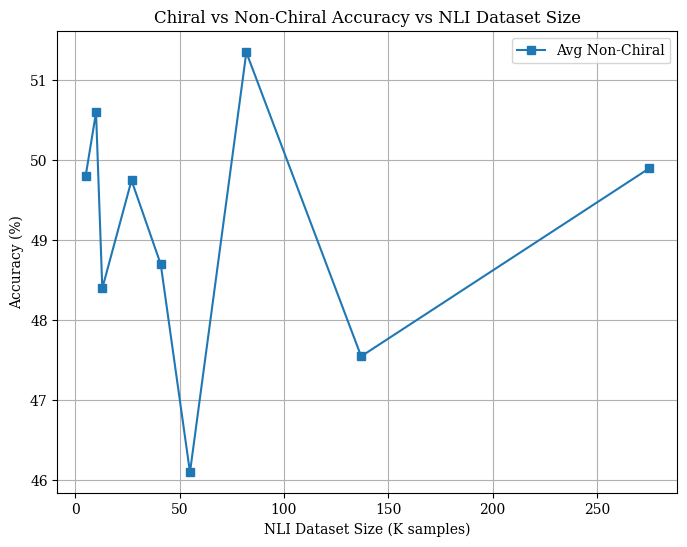

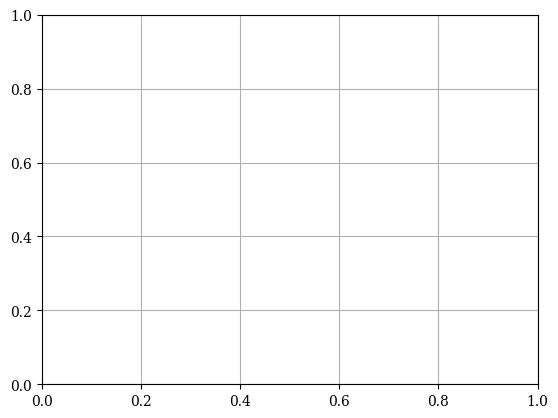

In [55]:
# Define the new dataset
data2 = {
    "NLI_size_k": [5, 10, 13, 27, 41, 55, 82, 137, 275],
    "V2T_Chiral": [81.9, 82.1, 80.1, 81.7, 81.7, 81.5, 82.0, 80.3, 81.3],
    "V2T_NonChiral": [60.1, 62.3, 58.7, 60.2, 59.4, 54.1, 62.0, 53.9, 53.6],
    "T2V_Chiral": [76.8, 79.6, 78.2, 79.6, 79.9, 81.4, 82.2, 82.5, 83.5],
    "T2V_NonChiral": [39.5, 38.9, 38.1, 39.3, 38.0, 38.1, 40.7, 41.2, 46.2]
}

df2 = pd.DataFrame(data2)

# Compute averages
df2["Avg_Chiral"] = df2[["V2T_Chiral", "T2V_Chiral"]].mean(axis=1)
df2["Avg_NonChiral"] = df2[["V2T_NonChiral", "T2V_NonChiral"]].mean(axis=1)

# Plot chiral vs non-chiral averages vs NLI dataset size
plt.figure(figsize=(8, 6))
# plt.plot(df2["NLI_size_k"], df2["Avg_Chiral"], marker="o", label="Avg Chiral")
plt.plot(df2["NLI_size_k"], df2["Avg_NonChiral"], marker="s", label="Avg Non-Chiral")
plt.xlabel("NLI Dataset Size (K samples)")
plt.ylabel("Accuracy (%)")
plt.title("Chiral vs Non-Chiral Accuracy vs NLI Dataset Size")
plt.legend()
plt.grid(True)
plt.show()

# Also plot the Chiral-NonChiral gap vs NLI size
df2["Chiral_NonChiral_Gap"] = df2["Avg_Chiral"] - df2["Avg_NonChiral"]

# plt.figure(figsize=(8, 6))
# plt.plot(df2["NLI_size_k"], df2["Chiral_NonChiral_Gap"], marker="d", color="purple")
# plt.xlabel("NLI Dataset Size (K samples)")
# plt.ylabel("Chiral - Non-Chiral Gap (Accuracy Points)")
# plt.title("Gap Between Chiral and Non-Chiral Accuracy vs NLI Dataset Size")
plt.grid(True)
plt.show()


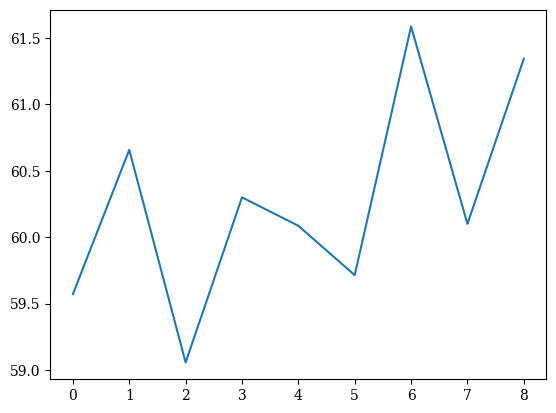

In [62]:
df_ = df2.copy() 
del df_['NLI_size_k']
plt.plot(df_.mean(axis=1).tolist())